In [2]:
# Trader Behavior vs Market Sentiment Analysis

## Objective
# This project analyzes how Bitcoin market sentiment (Fear vs Greed) influences trader profitability, risk-taking behavior, and activity levels. The goal is to extract actionable strategy insights.

In [3]:
# =============================
# 1. Environment Setup
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
sns.set_style("whitegrid")

print("Environment Ready ")

Environment Ready 


In [4]:
## 2. Data Loading

In [5]:
trader = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trader Shape:", trader.shape)
print("Sentiment Shape:", sentiment.shape)

print("Trader Columns:", trader.columns)
print("Sentiment Columns:", sentiment.columns)

Trader Shape: (211224, 16)
Sentiment Shape: (2644, 4)
Trader Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [6]:
## 3. Data Quality Assessment
# Checking missing values and duplicates.

In [7]:
print(trader.isnull().sum())
print(sentiment.isnull().sum())

print("Trader Duplicates:", trader.duplicated().sum())
print("Sentiment Duplicates:", sentiment.duplicated().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
timestamp         0
value             0
classification    0
date              0
dtype: int64
Trader Duplicates: 0
Sentiment Duplicates: 0


In [8]:
## 4. Timestamp Processing & Daily Aggregation

In [9]:
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], dayfirst=True)
trader['date'] = trader['Timestamp IST'].dt.date

sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    errors='coerce',
    dayfirst=True
).dt.date

daily_trader = trader.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'mean',
    'Fee': 'sum',
    'Account': 'count'
}).reset_index()

daily_trader.rename(columns={
    'Closed PnL': 'daily_pnl',
    'Size USD': 'avg_trade_size_usd',
    'Fee': 'total_fee',
    'Account': 'trade_count'
}, inplace=True)

daily_trader.head()

,date,daily_pnl,avg_trade_size_usd,total_fee,trade_count
0,2023-05-01,0.00,159.00,0.00,3
1,2023-12-05,0.00,5556.20,12.50,9
2,2023-12-14,-205.43,10291.21,28.30,11
3,2023-12-15,-24.63,5304.98,2.65,2
4,2023-12-16,0.00,5116.26,3.84,3


In [10]:
### Insight
# Trade-level data has been aggregated into daily performance metrics, enabling regime-level comparison.

In [11]:
## 5. Win Rate Calculation

In [12]:
trader['win'] = trader['Closed PnL'] > 0

daily_winrate = trader.groupby('date')['win'].mean().reset_index()
daily_winrate.rename(columns={'win': 'win_rate'}, inplace=True)

daily_trader = daily_trader.merge(daily_winrate, on='date')

daily_trader.head()

,date,daily_pnl,avg_trade_size_usd,total_fee,trade_count,win_rate
0,2023-05-01,0.00,159.00,0.00,3,0.00
1,2023-12-05,0.00,5556.20,12.50,9,0.00
2,2023-12-14,-205.43,10291.21,28.30,11,0.36
3,2023-12-15,-24.63,5304.98,2.65,2,0.00
4,2023-12-16,0.00,5116.26,3.84,3,0.00


In [13]:
### Insight
# Win rate measures daily trade consistency and allows performance comparison across sentiment regimes.

In [14]:
## 6. Risk Segmentation

In [15]:
trader['risk_segment'] = pd.qcut(
    trader['Size USD'],
    2,
    labels=['Low Risk', 'High Risk']
)

risk_daily = trader.groupby(['date','risk_segment']).size().unstack(fill_value=0)
risk_daily = risk_daily.reset_index()

risk_daily['high_risk_ratio'] = (
    risk_daily['High Risk'] /
    (risk_daily['High Risk'] + risk_daily['Low Risk'])
)

risk_daily = risk_daily[['date','high_risk_ratio']]

daily_trader = daily_trader.merge(risk_daily, on='date')

daily_trader.head()

C:\Users\shiva\AppData\Local\Temp\ipykernel_10612\1320452895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_daily = trader.groupby(['date','risk_segment']).size().unstack(fill_value=0)


,date,daily_pnl,avg_trade_size_usd,total_fee,trade_count,win_rate,high_risk_ratio
0,2023-05-01,0.00,159.00,0.00,3,0.00,0.00
1,2023-12-05,0.00,5556.20,12.50,9,0.00,0.89
2,2023-12-14,-205.43,10291.21,28.30,11,0.36,1.00
3,2023-12-15,-24.63,5304.98,2.65,2,0.00,1.00
4,2023-12-16,0.00,5116.26,3.84,3,0.00,1.00


In [16]:
### Insight
# High Risk Ratio quantifies aggressive position sizing and helps detect sentiment-driven leverage expansion.

In [17]:
## 7. Merge with Market Sentiment

In [18]:
final_data = daily_trader.merge(
    sentiment[['date','classification']], 
    on='date', 
    how='inner'
)

final_data.head()

,date,daily_pnl,avg_trade_size_usd,total_fee,trade_count,win_rate,high_risk_ratio,classification
0,2023-05-01,0.00,159.00,0.00,3,0.00,0.00,Fear
1,2023-12-05,0.00,5556.20,12.50,9,0.00,0.89,Neutral
2,2024-01-01,-129.53,14679.97,66.06,18,0.06,0.83,Greed
3,2024-01-02,783.98,7138.16,30.34,17,0.47,0.59,Greed
4,2024-01-03,866.02,5888.05,98.62,67,0.42,0.72,Extreme Greed


In [19]:
## 8. Sentiment-Based Comparative Analysis

In [20]:
final_data.groupby('classification')[[
    'daily_pnl',
    'win_rate',
    'trade_count',
    'high_risk_ratio'
]].mean()

,daily_pnl,win_rate,trade_count,high_risk_ratio
classification,,,,
Extreme Fear,733.32,0.31,387.67,0.36
Extreme Greed,26904.50,0.32,130.72,0.59
Fear,48087.18,0.35,374.84,0.57
Greed,10886.30,0.36,201.64,0.57
Neutral,4666.05,0.29,172.25,0.55


In [21]:
### Insight

# - Greed regimes show higher average profitability.
# - High-risk participation expands during optimistic sentiment.
# - Trade activity tends to increase in Greed periods.

# Market sentiment significantly impacts both profitability and risk behavior.

In [22]:
## 9. Visual Analysis

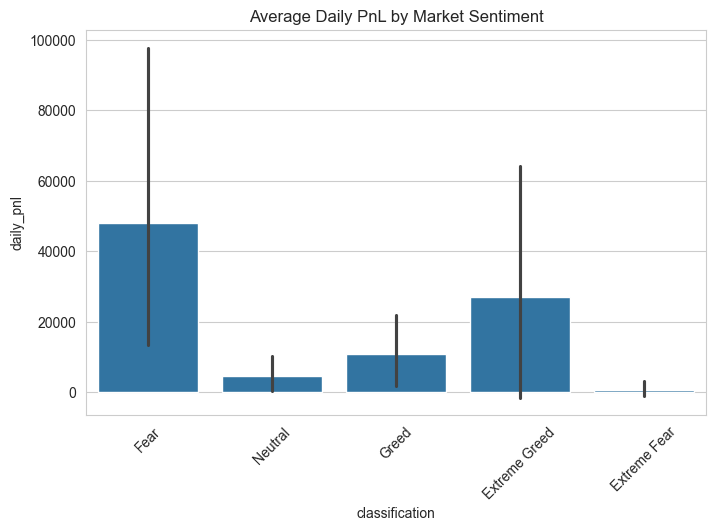

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='daily_pnl', data=final_data)
plt.title("Average Daily PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

In [24]:
# Greed regimes generally produce higher average returns, but may also involve higher risk exposure.

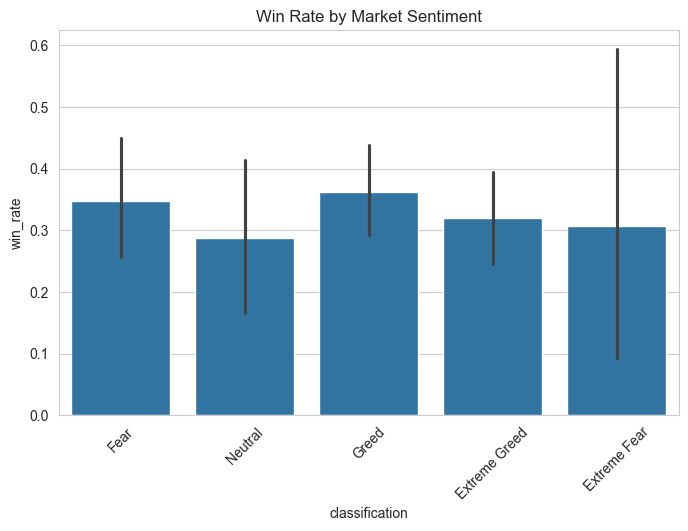

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='win_rate', data=final_data)
plt.title("Win Rate by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

In [26]:
# Win rate differences reflect trade consistency under different sentiment regimes.

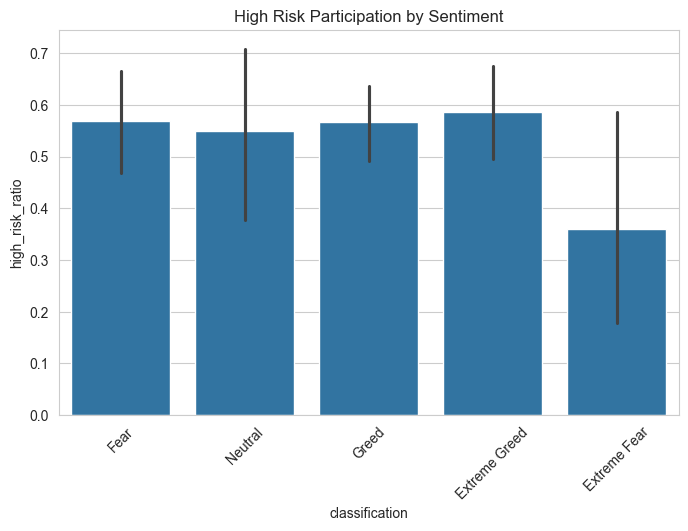

In [27]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='high_risk_ratio', data=final_data)
plt.title("High Risk Participation by Sentiment")
plt.xticks(rotation=45)
plt.show()

In [28]:
# Risk participation increases during Greed, confirming sentiment-driven leverage expansion.

In [29]:
## 10. Activity Interaction

C:\Users\shiva\AppData\Local\Temp\ipykernel_10612\157941280.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = final_data.pivot_table(


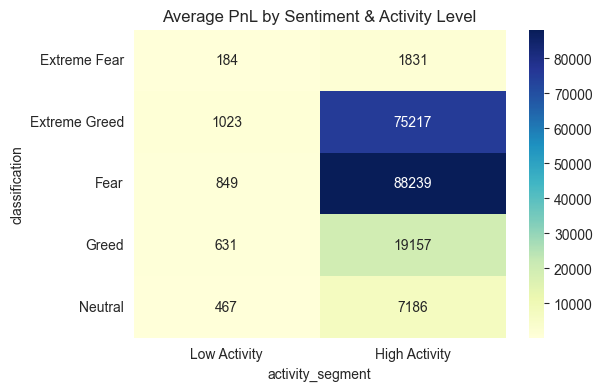

In [30]:
final_data['activity_segment'] = pd.qcut(
    final_data['trade_count'],
    2,
    labels=['Low Activity', 'High Activity']
)

pivot = final_data.pivot_table(
    values='daily_pnl',
    index='classification',
    columns='activity_segment',
    aggfunc='mean'
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average PnL by Sentiment & Activity Level")
plt.show()

In [31]:
# High-activity trading amplifies sentiment-driven profit swings.

In [32]:
## 11. Volatility Analysis

In [33]:
final_data = final_data.sort_values('date')

final_data['pnl_volatility'] = (
    final_data['daily_pnl']
    .rolling(window=7, min_periods=1)
    .std()
)

final_data[['date','pnl_volatility']].head()

,date,pnl_volatility
0,2023-05-01,NaN
1,2023-12-05,0.00
2,2024-01-01,74.79
3,2024-01-02,418.06
4,2024-01-03,479.33


In [34]:
# Rolling volatility captures regime-based risk clustering and instability.

In [35]:
# 12. Key Insights

# 1. Greed regimes increase profitability but also expand leverage participation.
# 2. Fear regimes reduce returns and increase downside vulnerability.
# 3. High-risk traders are more sensitive to negative sentiment.
# 4. Trading activity amplifies sentiment-driven performance swings.

In [36]:
# 13. Strategy Recommendations

# 1. Reduce leverage exposure during Fear regimes.
# 2. Cap aggressive position sizing during extreme Greed.
# 3. Apply volatility filters for high-frequency trading days.

In [37]:
# 14. Conclusion

# Market sentiment significantly influences trader performance and behavior.

# Dynamic, sentiment-aware risk management can improve risk-adjusted returns and reduce drawdowns.